## Support Vector Machines

#### *25 October 2019*
#### *DATA 1010*

In [1]:
using LinearAlgebra, Plots, Distributions, JuMP, Ipopt, Random
gr(fontfamily = "Palatino", size = (400,400), aspect_ratio = 1, legend = false); 

Consider a binary classification problem like this one:

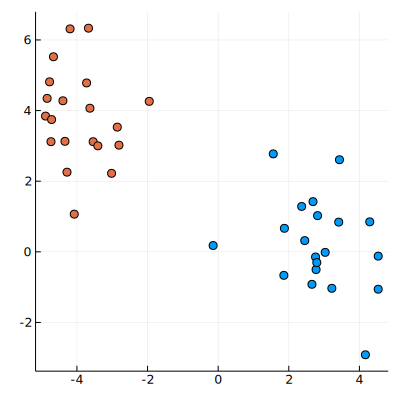

In [2]:
n = 20
Random.seed!(123)
X = [randn(n) .- 4 randn(n) .+ 4
     randn(n) .+ 3 randn(n)]
y = repeat([1,-1], inner = n)
function original_scatter()
    scatter(X[:, 1], X[:, 2], group = y)
end
original_scatter()

Setting aside probabilistic considerations, your visual cortex has an excellent idea for what to do: draw a line that separates the clusters as much as possible. Something like this:

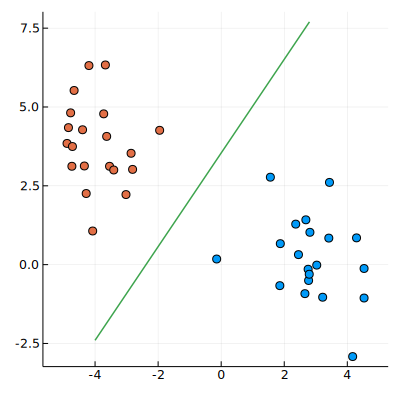

In [3]:
(a,b), (c,d) = (-4.0,-2.4), (2.8,7.7)
function add_line!()
    plot!([(a,b),(c,d)], linewidth = 1.5)
end
original_scatter()
add_line!()

This is the principle on which **support vector machines** are based. We look for a hyperplane (the solution set of a single linear equation; in other words, a line in 2D, an ordinary plane in 3D, etc.) which separates the clusters as much as possible. 

To quantify the the "as much as possible" idea, we introduce the idea of a separating slab:

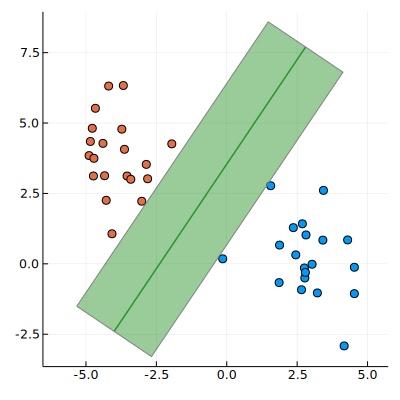

In [5]:
function slab(a,b,c,d,w)
    v = [b-d, c-a]
    v *= w/norm(v)
    Tuple.([[a,b] + v, [c,d] + v, [c,d] - v, [a,b] - v, [a,b] + v])
end
function add_slab!()
    plot!(slab(a,b,c,d,1.6), fillopacity = 0.4, seriestype = :shape, fillcolor = :green, linecolor = :gray)
end
original_scatter()
add_line!()
add_slab!()

(Note: we're defining the term *slab* mathematically here to mean the region between two parallel hyperplanes.)

We will look for the thickest separating slab and choose the hyperplane halfway between its boundaries as the decision surface. Note that the thickest separating slab necessarily has points on both boundaries; these points are called **support vectors**. 

---

## Problem 1

Suppose that the inequality for the slab is $\boldsymbol{\beta}' \mathbf{x} + \alpha \leq 1$. Then the width of the slab is $2/|\boldsymbol{\beta}|$. 

Use JuMP to find the thickest separating slab for the data shown above. Compare the result to the slab plotted above, which was obtained by eyeballing it. (Note: to compare, you can just call `add_slab!()` after you make your own plot below). 

*Solution*. 

In [6]:
mutable struct SVM
    X # training features
    y # training labels
    α
    β
    C # we'll use this later
    η # this too
end

SVM(X,y) = SVM(X,y,0,0,1,0)

SVM

In [7]:
function fit!(S::SVM)
    m = Model(with_optimizer(Ipopt.Optimizer, print_level=0))
    
end

fit! (generic function with 1 method)

In [8]:
S = SVM(X, y)
fit!(S)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt

In [9]:
import Plots.plot    
function plot(S::SVM)
    zone(t) = t > 1 ? 2 : (t > 0 ? 1 : (t > -1 ? -1 : -2))
    xmin, xmax = extrema(S.X[:,1])
    ymin, ymax = extrema(S.X[:,2])
    xmin -= (xmax - xmin)/20; xmax += (xmax - xmin)/20
    ymin -= (ymax - ymin)/20; ymax += (ymax - ymin)/20
    xgrid = range(xmin, xmax, length=512)
    ygrid = range(ymin, ymax, length=512)
    scatter(X[:,1], X[:,2], group = y, markersize = 2)
    contour!(xgrid, ygrid, (x,y) -> S.β'*[x,y] + S.α, 
              levels = [-1, 0, 1])
    heatmap!(xgrid, ygrid,
             (x,y) -> zone(S.β'*[x,y] + S.α), fillopacity = 0.5, 
             fillcolor = cgrad([:blue, :lightblue, :pink, :red]))
end

plot(S)

MethodError: MethodError: no method matching +(::Array{Float64,1}, ::Int64)
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  +(!Matched::Complex{Bool}, ::Real) at complex.jl:293
  +(!Matched::Missing, ::Number) at missing.jl:94
  ...

---

## Problem 2

The SVM described in Problem 1 is the *hard-margin* SVM; essentially we are paying an infinite price for every point which is either inside the slab or on the wrong side. A softer approach is to pay a *finite* price for that. Specifically, we will incur a penalty for each errant point which is proportional to the number of slab half-widths the point is from the correct side of the slab. This is called the *soft-margin* SVM. 

We can find the soft-margin SVM using JuMP as well. The minimization problem we want to solve is the following one: 

$$
\begin{array}{l}{\frac{1}{2}\|\boldsymbol{\beta}\|^{2}+C \mathbf{1}' \boldsymbol{\zeta}} \\ \text{subj. to }{\mathbf{y} \odot(X \boldsymbol{\beta}+\alpha \mathbf{1}) \succcurlyeq \mathbf{1}-\boldsymbol{\zeta} \text { and } \boldsymbol{\zeta} \succcurlyeq 0,}\end{array}
$$

where $\mathbf{1}$ denotes the vector of all ones (of whatever length makes sense), and where $\odot$ indicates elementwise multiplication. 

In [10]:
function fit!(S, C)
    
end

fit! (generic function with 2 methods)

In [11]:
S = SVM(X,y)
fit!(S, 1.0)
plot(S)

MethodError: MethodError: no method matching +(::Array{Float64,1}, ::Int64)
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  +(!Matched::Complex{Bool}, ::Real) at complex.jl:293
  +(!Matched::Missing, ::Number) at missing.jl:94
  ...

*Solution*. 

---

## Problem 3

The soft-margin SVM problem is equivalent to minimizing

$$
\frac{1}{2}\|\boldsymbol{\beta}\|^2 + C \mathbf{1}'\boldsymbol{\zeta} + H(\mathbf{1} - \boldsymbol{\zeta} -  \mathbf{y} \odot (X\boldsymbol{\beta} + \alpha\mathbf{1})) + H(-\boldsymbol{\zeta}). 
$$

where $H$ returns 0 for non-positive inputs and $\infty$ for positive inputs. This, in turn, is equivalent to 

$$
\min_{\alpha, \boldsymbol{\beta}, \boldsymbol{\zeta}} \max_{\boldsymbol{\eta}, \boldsymbol{\theta} \succcurlyeq \boldsymbol{0}}\left[\frac{1}{2}\|\boldsymbol{\beta}\|^2 + C \mathbf{1}'\boldsymbol{\zeta}  + \boldsymbol{\eta}'(\mathbf{1} - \boldsymbol{\zeta} -  \mathbf{y} \odot (X\boldsymbol{\beta} + \alpha\mathbf{1})) - \boldsymbol{\theta}'\zeta\right], 
$$

since $H(x) = \max_{\lambda \geq 0}( \lambda x)$. A result called Slater's Theorem tells us that in this case we can swap min and max, and that gives

$$
\begin{align*}
\max_{\boldsymbol{\eta}, \boldsymbol{\theta}\succcurlyeq \boldsymbol{0}}\min_{\alpha, \boldsymbol{\beta}, \boldsymbol{\zeta}} \Bigg[
&\frac{1}{2}\|\boldsymbol{\beta}\|^2 - \boldsymbol{\eta}' (\mathbf{y} \odot X\boldsymbol{\beta})
+ \boldsymbol{\eta}' \mathbf{1} + \\
&(C \mathbf{1}' - \boldsymbol{\eta}' - \boldsymbol{\theta}') \boldsymbol{\zeta} \\
&-\alpha\boldsymbol{\eta}'\mathbf{y}\Bigg]. 
\end{align*}
$$

(a) Differentiate the expression on the first line to find the minimizing value of $\boldsymbol{\beta}$.  

(b) What has to be true of $\boldsymbol{\eta}$ in order for the minimum in this expression to be anything other than $-\infty$?

(c) Use the code below to view the values of $\mathbf{\eta}$ for each training observation. Draw some conclusions based on what you see. 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



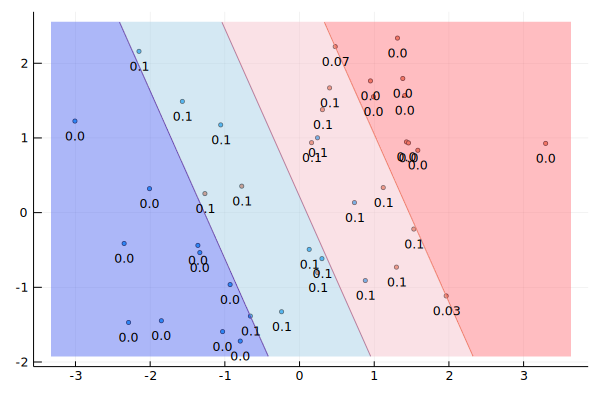

In [12]:
function dualfit!(S::SVM, C)
    S.C = C
    nrows, ncols = size(S.X)
    model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))
    @variable(model, η[1:nrows])
    @variable(model, α)
    @objective(model, Max, -1/2 * (η .* S.y)' * X * X' * (η .* S.y) + sum(η))
    @constraint(model, 0 .≤ η[1:nrows] .≤ S.C)
    @constraint(model, η' * S.y == 0)
    optimize!(model)
    S.η = value.(η)
    support_vectors = 1e-2 .<  S.η .< S.C - 1e-2
    S.β = S.X' * (S.η .* S.y)
    S.α = mean((S.y - X * S.β)[support_vectors])
    nothing
end

function plot(S::SVM, f::Function)
    P = plot(S)
    annotate!(P, [(S.X[i,1],S.X[i,2]-0.2,
                  text("$(abs(round(f(S,i),digits=2)))",8)) for i in 1:size(S.X,1)])
    plot!(P, size = (600,400))
    P
end

using Random; Random.seed!(1)
X = [randn(n) .+ 1 randn(n) .+ 1
     randn(n) .- 1 randn(n)]
y = repeat([1,-1], inner = n)
S = SVM(X, y)
dualfit!(S, 0.1)
plot(S, (S,i) -> S.η[i])

*Solution*. 

In [13]:
using Pkg; Pkg.add("MLDatasets"); Pkg.add("LIBSVM")

 Resolving package versions...
  Updating `/opt/julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `/opt/julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `/opt/julia/environments/v1.2/Project.toml`
  [b1bec4e5] + LIBSVM v0.3.1
  Updating `/opt/julia/environments/v1.2/Manifest.toml`
 [no changes]


In [14]:
using MLDatasets
import LIBSVM

┌ Info: Precompiling MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458]
└ @ Base loading.jl:1242
ERROR: LoadError: LoadError: error compiling top-level scope: could not load library "libz"
libz.so: cannot open shared object file: No such file or directory
Stacktrace:
 [1] include at ./boot.jl:328 [inlined]
 [2] include_relative(::Module, ::String) at ./loading.jl:1094
 [3] include at ./Base.jl:31 [inlined]
 [4] include(::String) at /opt/julia/packages/GZip/LD2ly/src/GZip.jl:2
 [5] top-level scope at /opt/julia/packages/GZip/LD2ly/src/GZip.jl:73
 [6] include at ./boot.jl:328 [inlined]
 [7] include_relative(::Module, ::String) at ./loading.jl:1094
 [8] include(::Module, ::String) at ./Base.jl:31
 [9] top-level scope at none:2
 [10] eval at ./boot.jl:330 [inlined]
 [11] eval(::Expr) at ./client.jl:432
 [12] top-level scope at ./none:3
in expression starting at /opt/julia/packages/GZip/LD2ly/src/zlib_h.jl:11
in expression starting at /opt/julia/packages/GZip/LD2ly/src/GZip.jl:73
caused by [

ErrorException: Failed to precompile MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458] to /home/jovyan/.julia/compiled/v1.2/MLDatasets/9CUQK.ji.

---

## Problem 4

Training support vector machines on large datasets requires special numerical methods to achieve reasonable performance. A lot of work has gone into doing this well, in the form of the library LIBSVM. LIBSVM has bindings for every major computing environment, including Julia. In this problem, we will use LIBSVM to determine whether there is a separating hyperplane between the zeros images and ones images in the MNIST training data.

The code below computes a soft-margin SVM a high $C$ value. Project every point in the dataset onto the vector $\beta$ and determine whether the zeros and ones are fully separated in that direction.

*Solution*. 

In [15]:
features, labels = MNIST.traindata()
features = reshape(features[:, :, labels .∈ Ref((0, 1))], (28^2, :))
labels = labels[labels .∈ Ref((0,1))];
#labels[labels .== 0] .= -1;
Gray.(reshape(1 .- features[:,1], (28, 28)))

UndefVarError: UndefVarError: MNIST not defined

In [16]:
model = LIBSVM.svmtrain(float(features), float(labels), kernel = LIBSVM.Kernel.Linear, cost = 100.0);

UndefVarError: UndefVarError: features not defined

In [17]:
# this is how to recover the value of β from the data stored in the model during training:
β = model.SVs.X * model.coefs

UndefVarError: UndefVarError: model not defined